<a href="https://colab.research.google.com/github/ArtuomMerkulov/ArtuomMerkulov/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B4%D0%BE%D1%80%D0%BE%D0%B3_%D0%B8_%D0%B4%D0%BE%D0%BC%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D0%9A%D0%B0%D1%80%D1%82_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение бибилиотек


In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация рук

## Загрузка картинок



In [3]:
!unzip -q '/content/drive/MyDrive/Numpy/maps segmentation.zip' 

In [4]:
img_width = 176 
img_height = 240 
num_classes = 5
directory = '/content/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'JPEGImages' # Название папки с файлами обучающей выборки
val_directory = 'SegmentationClass' # Название папки с файлами проверочной выборки

### Оригинальные изображения



In [5]:
train_images = [] 
val_images = [] 

cur_time = time.time()
for filename in sorted(os.listdir(directory + train_directory)): 
    train_images.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_images)) 

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory)):                 
    val_images.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))    
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_images)) 

Обучающая выборка загржуена. Время загрузки: 0.46c
Количество изображений:  50
Проверочная выборка загржуена. Время загрузки: 0.18c
Количество изображений:  50


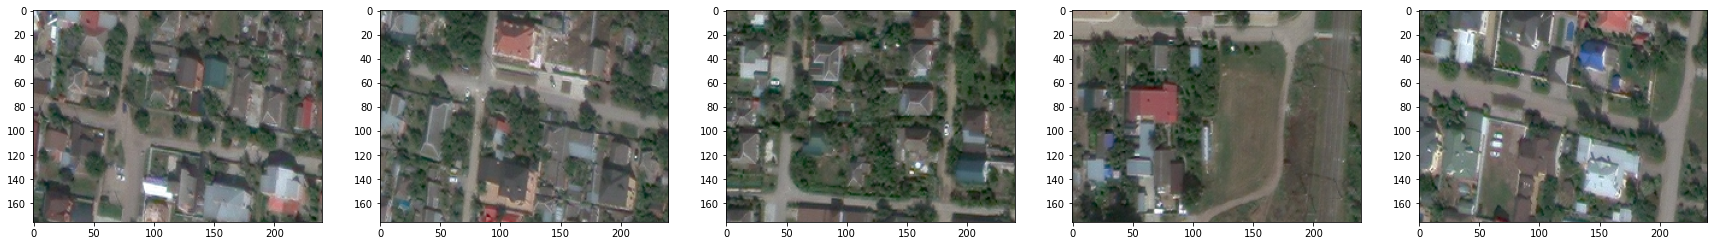

In [6]:
n = 5
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img) 
plt.show() 

### Сегментированные изображения

In [7]:
train_segments = [] 
val_segments = [] 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory)): 
    train_segments.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_segments))

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory)):                                                     
    val_segments.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))     
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_segments))

Обучающая выборка загржуена. Время загрузки: 0.44c
Количество изображений:  50
Проверочная выборка загржуена. Время загрузки: 0.18c
Количество изображений:  50


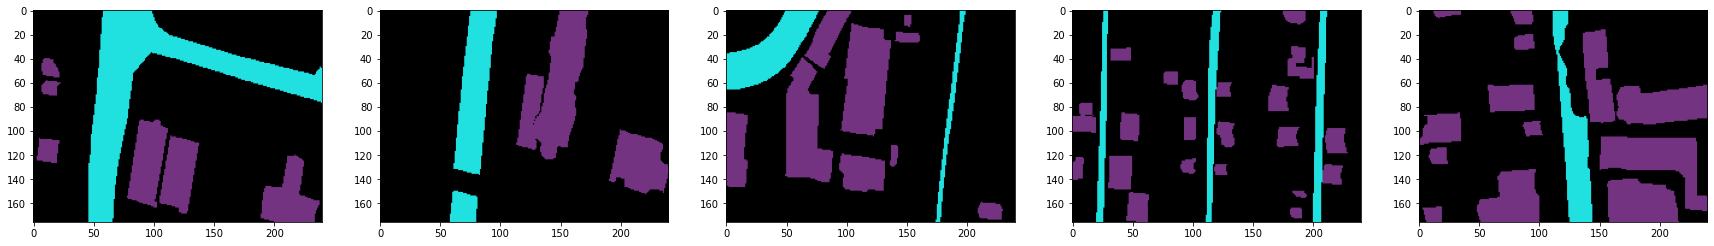

In [8]:
n = 5
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(val_segments) 
  axs[i].imshow(img) 
plt.show() 

### Создание выборки



In [9]:
def color2index(color):
    index = -1
    if (51>=color[0]>=0)   and (51>=color[1]>=0)  and (51>=color[2]>=0) : index=0 # фон
    elif (130>=color[0]>=51)    and (130>=color[1]>=51)  and (155>=color[2]>=51) : index=1 # дороги
    elif (51>=color[0]>=0)    and (255>=color[1]>=0)  and (255>=color[2]>=0) : index=2 # дома
    else: index=3
    return index  

In [10]:
def index2color(index2):
    index = np.argmax(index2) 
    color = []
    if index == 0: color = [0, 0, 0]      
    elif index == 1: color = [115, 51, 128]  
    elif index == 2: color = [32, 224, 224]  
    elif index == 3: color = [127, 255, 255]   
    return color

In [11]:
def rgbToohe(y, num_classes): 
    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3) 
    yt = [] 
    for i in range(len(y)): 
      yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    yt = np.array(yt) 
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) 
    return yt 

In [12]:
def yt_prep(data, num_classes):
    yTrain = [] 
    for seg in data: 
        y = image.img_to_array(seg) 
        y = rgbToohe(y, num_classes)
        yTrain.append(y) 
        if len(yTrain) % 100 == 0: 
            print(len(yTrain)) 
    return np.array(yTrain) 

In [13]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(50, 176, 240, 3)
(50, 176, 240, 3)


In [14]:
cur_time = time.time() 
yTrain = yt_prep(train_segments, num_classes)  
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

Время обработки:  54.62 c


In [15]:
cur_time = time.time() 
yVal = yt_prep(val_segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

Время обработки:  55.33 c


In [16]:
yTrain.shape

(50, 176, 240, 5)

In [17]:
yVal.shape

(50, 176, 240, 5)

## Модели


In [18]:
def processImage(model, count = 1, n_classes = 5):
    indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(30, 15)) #Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    plt.show()  

### U-net



In [19]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [20]:
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [21]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) 
history = modelUnet.fit(xTrain, yTrain, epochs=25, batch_size=50, validation_data = (xVal, yVal)) 

Epoch 1/25
1/1 [==============================] - 96s 96s/step - loss: 1.9587 - dice_coef: 0.1930 - val_loss: 3.0192 - val_dice_coef: 0.1538
Epoch 2/25
1/1 [==============================] - 88s 88s/step - loss: 1.1780 - dice_coef: 0.3615 - val_loss: 5.7113 - val_dice_coef: 0.1631
Epoch 3/25
1/1 [==============================] - 88s 88s/step - loss: 0.8200 - dice_coef: 0.5078 - val_loss: 7.7191 - val_dice_coef: 0.1879
Epoch 4/25
1/1 [==============================] - 87s 87s/step - loss: 0.6267 - dice_coef: 0.6138 - val_loss: 9.4409 - val_dice_coef: 0.2092
Epoch 5/25
1/1 [==============================] - 87s 87s/step - loss: 0.5046 - dice_coef: 0.6825 - val_loss: 10.8667 - val_dice_coef: 0.2209
Epoch 6/25
1/1 [==============================] - 87s 87s/step - loss: 0.4215 - dice_coef: 0.7319 - val_loss: 11.7674 - val_dice_coef: 0.2218
Epoch 7/25
1/1 [==============================] - 87s 87s/step - loss: 0.3725 - dice_coef: 0.7633 - val_loss: 11.9764 - val_dice_coef: 0.2219
Epoch 8/25

In [22]:
modelUnet.save_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelUnet.h5')

#### Распознавание



In [23]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
modelUnet.load_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelUnet.h5')

1/1 [==============================] - 0s 454ms/step


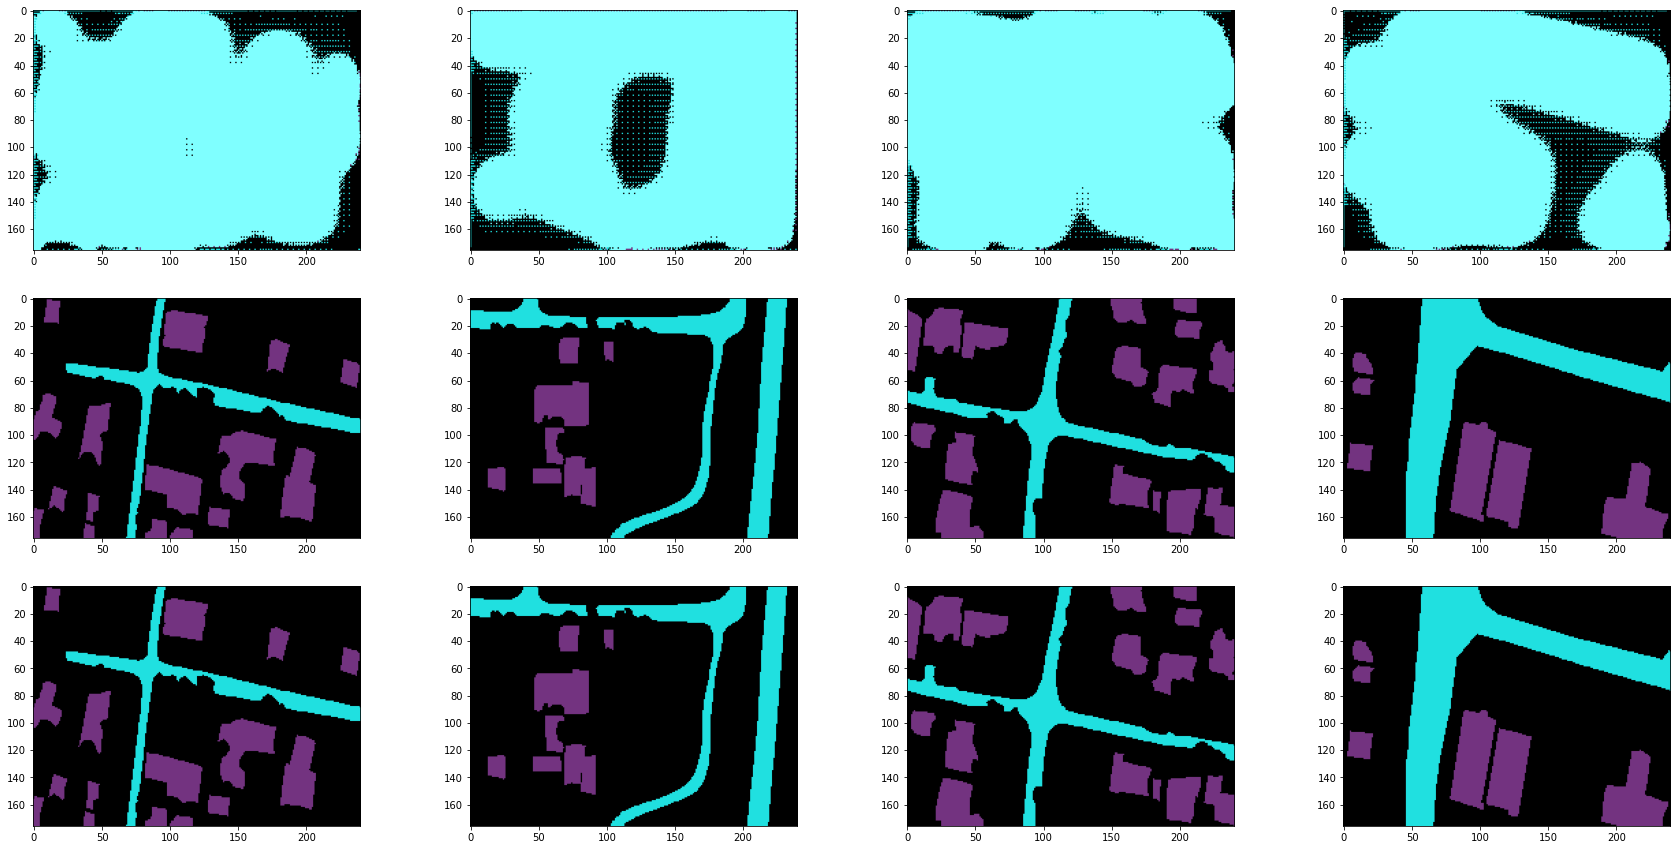

In [34]:
processImage(modelUnet, 4, num_classes)